In [ ]:
!pip install polars pandas joblib scikit-learn xgboost pyarrow matplotlib numpy --upgrade
import polars as pl
from pathlib import Path

# Define paths
DATA_DIR = Path("data/backblaze")
OUTPUT_PARQUET = "hdd_full_clean.parquet"

# Key columns you want
KEEP_COLS = [
    "date", "serial_number", "model", "failure",
    "smart_5_raw", "smart_9_raw", "smart_187_raw",
    "smart_194_raw", "smart_197_raw", "smart_198_raw"
]

# Find all CSVs recursively
csv_files = list(DATA_DIR.glob("**/*.csv"))
print(f"Found {len(csv_files)} CSV files.")

# --- SOLUTION: Iterative Read and Concatenate ---

lazy_frames = []

print("Scanning individual files...")
for file in csv_files:
    try:
        # Get column names for the current file using the recommended method
        available_cols = pl.scan_csv(file, n_rows=0).collect_schema().names()
        
        # Scan each file individually
        lf_single = pl.scan_csv(
            file,
            infer_schema_length=0,
            ignore_errors=True
        ).select(
            # Keep only the columns that exist in this specific file
            [col for col in KEEP_COLS if col in available_cols]
        )
        lazy_frames.append(lf_single)
    except Exception as e:
        print(f"⚠️ Could not process file: {file}. Error: {e}")

# Concatenate all the lazy frames together
print("Combining all files...")
lf = pl.concat(
    lazy_frames,
    how="diagonal",
    rechunk=True
)

# --- Data Cleaning and Type Casting ---

lf = lf.with_columns([
    pl.col("date").str.strptime(pl.Date, "%Y-%m-%d"),
    pl.col("failure").cast(pl.Int8),
    pl.col(
        "smart_5_raw", "smart_9_raw", "smart_187_raw",
        "smart_194_raw", "smart_197_raw", "smart_198_raw"
    ).cast(pl.Int64).fill_null(0),
])

# --- Execution and Saving ---

print("Executing the plan and collecting data...")
df = lf.collect()

# Save the final DataFrame
df.write_parquet(OUTPUT_PARQUET)
print(f"✅ Saved {df.height:,} rows to {OUTPUT_PARQUET}")
print(f"Failures: {df['failure'].sum()}")

Found 1072 CSV files.
Scanning individual files...
Combining all files...
Executing the plan and collecting data...


In [ ]:
df.head()

date,serial_number,model,failure,smart_5_raw,smart_9_raw,smart_187_raw,smart_194_raw,smart_197_raw,smart_198_raw
date,str,str,i8,i64,i64,i64,i64,i64,i64
2022-11-05,"""PL1331LAGDJ5GH""","""HGST HDS5C4040ALE630""",0,0,47298,0,25,0,0
2022-11-05,"""PL2331LAGLW5UJ""","""HGST HMS5C4040BLE640""",0,0,73653,0,23,0,0
2022-11-05,"""PL2331LAGM410J""","""HGST HMS5C4040BLE640""",0,0,73662,0,25,0,0
2022-11-05,"""PL2331LAGM5NTJ""","""HGST HMS5C4040BLE640""",0,0,73654,0,23,0,0
2022-11-05,"""PL2331LAGM5R4J""","""HGST HMS5C4040BLE640""",0,0,73654,0,23,0,0


In [ ]:
import polars as pl
import numpy as np

# Load and sort the data ONCE. This is crucial.
df = pl.read_parquet(OUTPUT_PARQUET).sort("serial_number", "date")

# Define constants
SMART_COLS = [
    "smart_5_raw", "smart_9_raw", "smart_187_raw",
    "smart_194_raw", "smart_197_raw", "smart_198_raw"
]
WINDOW_SIZE = 30
MIN_SEQ_LEN = 10

# --- Vectorized Feature Engineering ---

# Define expressions to determine the slice (window) for each group
fail_idx = pl.col("failure").arg_max()
group_len = pl.len()  # <-- FIX 1: Replaced pl.count() with pl.len()
is_failed = pl.col("failure").max() == 1

# For failed drives, the slice starts before the failure index.
# For healthy drives, we deterministically take the LAST `WINDOW_SIZE` days.
start_idx = (
    pl.when(is_failed)
    # FIX 2: Use pl.max_horizontal for element-wise max between expressions
    .then(pl.max_horizontal([pl.lit(0), fail_idx - WINDOW_SIZE + 1]))
    .otherwise(group_len - WINDOW_SIZE)
)

# Length of the slice depends on whether it's a failure or a healthy window
slice_len = (
    pl.when(is_failed)
    .then(fail_idx - start_idx + 1)
    .otherwise(WINDOW_SIZE)
)

# Now, build the list of aggregation expressions
agg_exprs = []
for col in SMART_COLS:
    sequence = pl.col(col).slice(start_idx, slice_len)
    time_index = pl.int_range(0, sequence.len())
    trend = pl.cov(time_index, sequence) / time_index.var().fill_null(0.0)

    agg_exprs.extend([
        sequence.last().alias(f"{col}_last"),
        sequence.mean().alias(f"{col}_mean"),
        sequence.std().fill_null(0.0).alias(f"{col}_std"),
        trend.alias(f"{col}_trend"),
    ])

# Execute the entire logic in one go
df_seq = df.group_by("serial_number", maintain_order=True).agg(
    *agg_exprs,
    pl.col("failure").max().alias("failure"),
    slice_len.alias("seq_len")
).filter(
    pl.col("seq_len") >= MIN_SEQ_LEN
).drop("seq_len")

# Save final model-ready dataset
df_seq.write_parquet("hdd_sequences_efficient.parquet")
print(f"✅ Created {df_seq.height} sequences. Failures: {df_seq['failure'].sum()}")

✅ Created 277880 sequences. Failures: 6107


  Using cached matplotlib-3.10.6-cp313-cp313-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.0-cp313-cp313-macosx_10_13_universal2.whl.metadata (111 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pillow-11.3.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.6-cp313-cp313-macosx_11_0_arm64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl (274 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.60.0-cp313-cp313-macosx_10_13_universal2.whl (2.8 MB)
Using cached kiwisolver-1.4.9-cp313-cp313-macosx_11_0_arm64.whl (64 kB)
Using cached pillow-11.3.0-cp313-cp313-macosx_11_0_arm64.whl (4.7 MB)
Using cached pyparsing-3.2.5

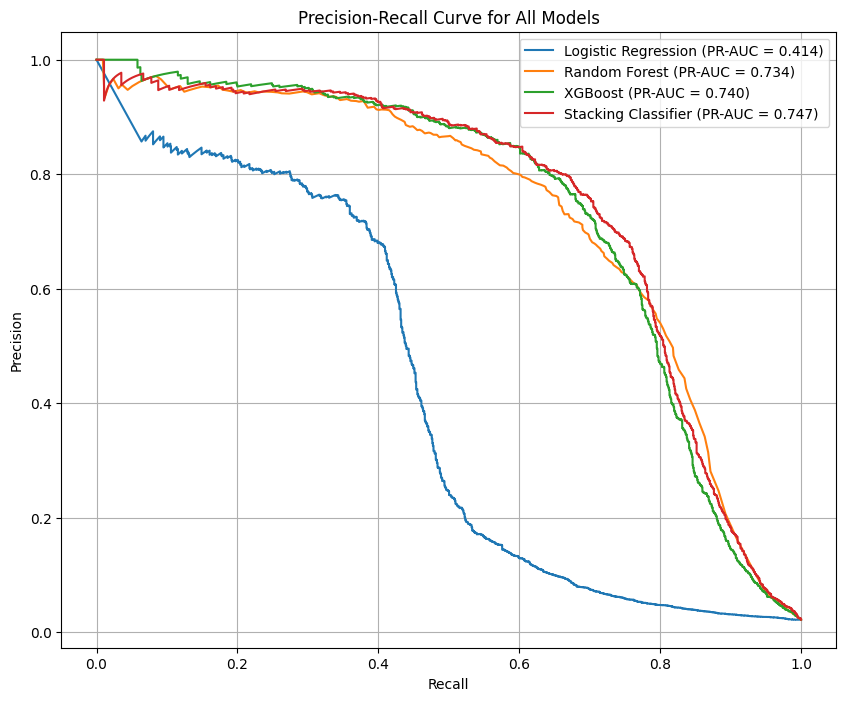

In [ ]:
!pip install matplotlib
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, fbeta_score, precision_recall_curve,
    auc, recall_score, precision_score
)
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier # <-- Import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline # <-- Import Pipeline

# Load and clean data
df_seq = pl.read_parquet("hdd_sequences_efficient.parquet")
df_seq = df_seq.drop_nulls(subset=["failure"])
X_pl = df_seq.drop(["failure", "serial_number"])
float_cols = X_pl.select(pl.col(pl.Float64)).columns
X_pl = (
    X_pl.fill_null(0).with_columns(
        [
            pl.when(pl.col(c).is_infinite()).then(0).otherwise(pl.col(c)).alias(c)
            for c in float_cols
        ]
    )
)
X = X_pl.to_pandas()
y = df_seq["failure"].to_pandas()

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- NEW: Define the Stacking Classifier ---

# 1. Create a pipeline for Logistic Regression to handle scaling internally
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
])

# 2. Define the list of base estimators for the stack
base_estimators = [
    ('random_forest', RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, class_weight='balanced')),
    ('xgboost', XGBClassifier(n_estimators=200, tree_method="hist", n_jobs=-1, random_state=42, scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]))),
    ('logreg_pipe', lr_pipe) # Use the pipeline here
]

# 3. Define the final meta-model
final_estimator = LogisticRegression(max_iter=1000)

# 4. Create the Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_estimator,
    cv=5 # Use cross-validation to generate predictions for the meta-model
)

# --- Define models, now including the Stacking Classifier ---
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000, random_state=42, class_weight='balanced'
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, n_jobs=-1, random_state=42, class_weight='balanced'
    ),
    "XGBoost": XGBClassifier(
        n_estimators=200, tree_method="hist", n_jobs=-1, random_state=42,
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])
    ),
    "Stacking Classifier": stacking_clf # <-- Add the new model
}

# --- Lists to store results ---
results = []
plot_data = []

# --- Loop, Train, and Evaluate (NO CHANGES NEEDED HERE) ---
for name, model in models.items():
    print(f"=== {name} ===")

    # Handle scaling for the standalone Logistic Regression
    if name == "Logistic Regression":
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # The Stacking Classifier will handle its own internal scaling via the pipeline
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

    # Store results for summary table
    results.append({
        "Model": name,
        "F2-Score": fbeta_score(y_test, y_pred, beta=2),
        "Recall": recall_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred)
    })

    # Store data for the combined PR Curve plot
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plot_data.append({
        'model_name': name,
        'recall': recall,
        'precision': precision,
        'pr_auc': auc(recall, precision)
    })

# --- Create Summary Table from Loop Results ---
summary_df = pl.DataFrame(results).sort("F2-Score", descending=True)
print("\n--- Model Performance Summary ---")
print(summary_df)

# --- Plot Combined Precision-Recall Curve ---
plt.figure(figsize=(10, 8))
for data in plot_data:
    plt.plot(
        data['recall'],
        data['precision'],
        label=f"{data['model_name']} (PR-AUC = {data['pr_auc']:.3f})"
    )
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for All Models')
plt.legend()
plt.grid(True)
plt.show()

=== Logistic Regression ===
=== Random Forest ===
=== XGBoost ===
=== Stacking Classifier ===

--- Model Performance Summary ---
shape: (4, 3)
┌─────────────────────┬───────────────┬────────────────┐
│ Model               ┆ Test F2-Score ┆ Train F2-Score │
│ ---                 ┆ ---           ┆ ---            │
│ str                 ┆ f64           ┆ f64            │
╞═════════════════════╪═══════════════╪════════════════╡
│ XGBoost             ┆ 0.713444      ┆ 0.891476       │
│ Stacking Classifier ┆ 0.674454      ┆ 0.97567        │
│ Random Forest       ┆ 0.582216      ┆ 1.0            │
│ Logistic Regression ┆ 0.390987      ┆ 0.384969       │
└─────────────────────┴───────────────┴────────────────┘


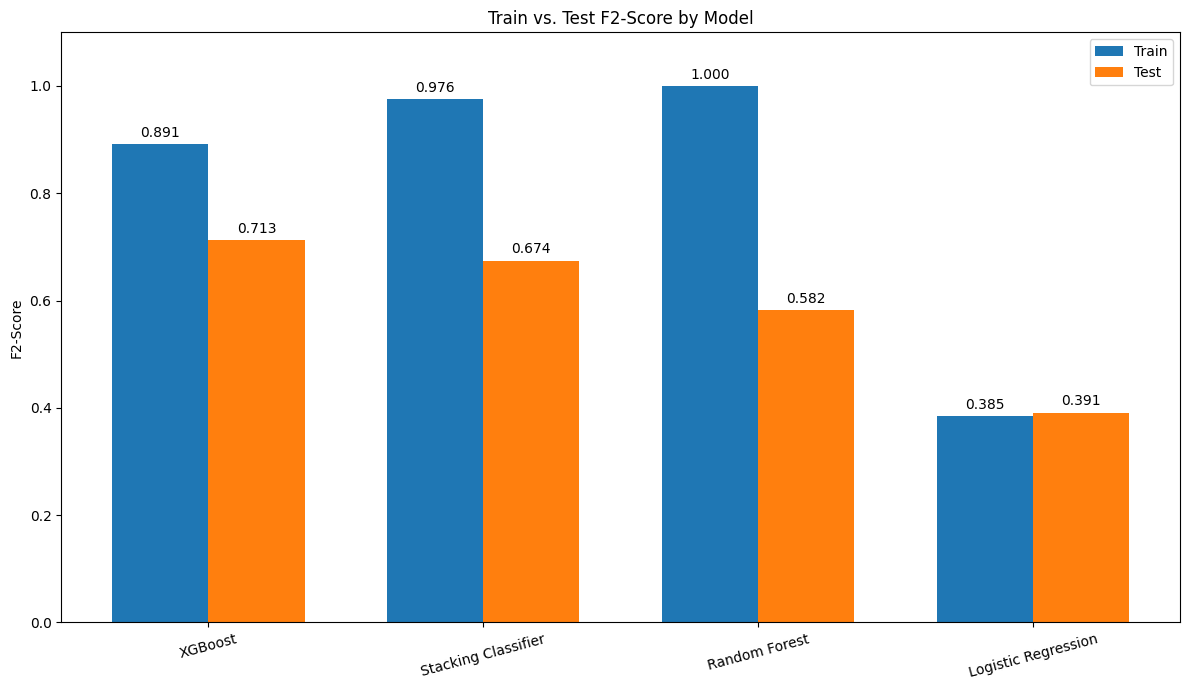

In [ ]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # <-- Import NumPy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, fbeta_score, precision_recall_curve,
    auc, recall_score, precision_score
)
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Load and clean data
df_seq = pl.read_parquet("hdd_sequences_efficient.parquet")
df_seq = df_seq.drop_nulls(subset=["failure"])
X_pl = df_seq.drop(["failure", "serial_number"])
float_cols = X_pl.select(pl.col(pl.Float64)).columns
X_pl = (
    X_pl.fill_null(0).with_columns(
        [
            pl.when(pl.col(c).is_infinite()).then(0).otherwise(pl.col(c)).alias(c)
            for c in float_cols
        ]
    )
)
X = X_pl.to_pandas()
y = df_seq["failure"].to_pandas()

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define models and Stacking Classifier
lr_pipe = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))])
base_estimators = [
    ('random_forest', RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, class_weight='balanced')),
    ('xgboost', XGBClassifier(n_estimators=200, tree_method="hist", n_jobs=-1, random_state=42, scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]))),
    ('logreg_pipe', lr_pipe)
]
final_estimator = LogisticRegression(max_iter=1000)
stacking_clf = StackingClassifier(estimators=base_estimators, final_estimator=final_estimator, cv=5)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(n_estimators=200, tree_method="hist", n_jobs=-1, random_state=42, scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])),
    "Stacking Classifier": stacking_clf
}

# List to store results
results = []

# --- Loop, Train, and Evaluate ---
for name, model in models.items():
    print(f"=== {name} ===")

    if name == "Logistic Regression":
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        model.fit(X_train_scaled, y_train)
        y_pred_test = model.predict(X_test_scaled)
        y_pred_train = model.predict(X_train_scaled) # <-- Predict on train set
    else:
        model.fit(X_train, y_train)
        y_pred_test = model.predict(X_test)
        y_pred_train = model.predict(X_train) # <-- Predict on train set

    # Calculate metrics for both test and train sets
    f2_test = fbeta_score(y_test, y_pred_test, beta=2)
    f2_train = fbeta_score(y_train, y_pred_train, beta=2) # <-- Calculate train score

    # Store results
    results.append({
        "Model": name,
        "Test F2-Score": f2_test,
        "Train F2-Score": f2_train
    })

# --- Create Summary Table from Loop Results ---
summary_df = pl.DataFrame(results).sort("Test F2-Score", descending=True)
print("\n--- Model Performance Summary ---")
print(summary_df)

# --- Plot Train vs. Test Scores ---
model_names = summary_df["Model"].to_numpy()
test_scores = summary_df["Test F2-Score"].to_numpy()
train_scores = summary_df["Train F2-Score"].to_numpy()

x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, train_scores, width, label='Train')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test')

ax.set_ylabel('F2-Score')
ax.set_title('Train vs. Test F2-Score by Model')
ax.set_xticks(x, model_names, rotation=15)
ax.legend()
ax.bar_label(rects1, padding=3, fmt='%.3f')
ax.bar_label(rects2, padding=3, fmt='%.3f')
ax.set_ylim(0, 1.1)
fig.tight_layout()
plt.show()


--- Fitting XGBoost with evaluation sets ---


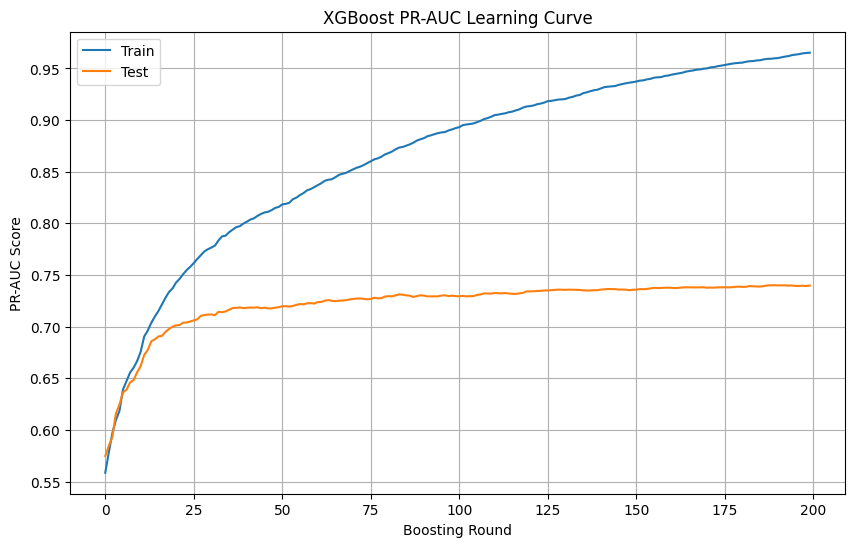

In [ ]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, fbeta_score, precision_recall_curve,
    auc, recall_score, precision_score
)
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Load and clean data
df_seq = pl.read_parquet("hdd_sequences_efficient.parquet")
df_seq = df_seq.drop_nulls(subset=["failure"])
X_pl = df_seq.drop(["failure", "serial_number"])
float_cols = X_pl.select(pl.col(pl.Float64)).columns
X_pl = (
    X_pl.fill_null(0).with_columns(
        [
            pl.when(pl.col(c).is_infinite()).then(0).otherwise(pl.col(c)).alias(c)
            for c in float_cols
        ]
    )
)
X = X_pl.to_pandas()
y = df_seq["failure"].to_pandas()

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- FIX 1: Add eval_metric to the XGBoost constructor ---
xgb_params = {
    'n_estimators': 200,
    'tree_method': "hist",
    'n_jobs': -1,
    'random_state': 42,
    'scale_pos_weight': (y_train.value_counts()[0] / y_train.value_counts()[1]),
    'eval_metric': 'aucpr' # <-- Set the metric here
}

# Define models and Stacking Classifier
lr_pipe = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))])
base_estimators = [
    ('random_forest', RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, class_weight='balanced')),
    ('xgboost', XGBClassifier(**xgb_params)),
    ('logreg_pipe', lr_pipe)
]
final_estimator = LogisticRegression(max_iter=1000)
stacking_clf = StackingClassifier(estimators=base_estimators, final_estimator=final_estimator, cv=5)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(**xgb_params),
    "Stacking Classifier": stacking_clf
}

# (The main training loop and summary table generation would go here as before)
# ...

# --- Plotting XGBoost's Learning Curve ---

# Isolate the XGBoost model
xgb_model = models["XGBoost"]

# Define the evaluation sets
eval_set = [(X_train, y_train), (X_test, y_test)]

# --- FIX 2: Remove eval_metric from the .fit() call ---
print("\n--- Fitting XGBoost with evaluation sets ---")
xgb_model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=False
)

# Retrieve the results
results = xgb_model.evals_result()
epochs = len(results['validation_0']['aucpr'])
x_axis = range(0, epochs)

# Plot the learning curve
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_axis, results['validation_0']['aucpr'], label='Train')
ax.plot(x_axis, results['validation_1']['aucpr'], label='Test')
ax.legend()
plt.ylabel('PR-AUC Score')
plt.xlabel('Boosting Round')
plt.title('XGBoost PR-AUC Learning Curve')
plt.grid(True)
plt.show()

In [ ]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV # <-- Import
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, fbeta_score, make_scorer # <-- Import
)
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# --- Load and Clean Data ---
# (Assuming the previous data loading and cleaning steps are here)
df_seq = pl.read_parquet("hdd_sequences_efficient.parquet")
df_seq = df_seq.drop_nulls(subset=["failure"])
X_pl = df_seq.drop(["failure", "serial_number"])
float_cols = X_pl.select(pl.col(pl.Float64)).columns
X_pl = (
    X_pl.fill_null(0).with_columns(
        [
            pl.when(pl.col(c).is_infinite()).then(0).otherwise(pl.col(c)).alias(c)
            for c in float_cols
        ]
    )
)
X = X_pl.to_pandas()
y = df_seq["failure"].to_pandas()

# --- Split Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ===================================================================
# --- NEW: HYPERPARAMETER TUNING SECTION ---
# ===================================================================

print("\n--- Starting Hyperparameter Tuning for XGBoost ---")

# 1. Define the base XGBoost model to be tuned
# We use the original constructor without n_estimators, as it will be tuned
xgb_tune = XGBClassifier(
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    eval_metric='aucpr'
)

# 2. Define the parameter distribution for Randomized Search
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# 3. Create a custom scorer to optimize for the F2-score
f2_scorer = make_scorer(fbeta_score, beta=2)

# 4. Set up RandomizedSearchCV
# n_iter: number of parameter settings that are sampled (higher is better but slower)
# cv: number of cross-validation folds
random_search = RandomizedSearchCV(
    estimator=xgb_tune,
    param_distributions=param_dist,
    n_iter=50,  # Try 50 different combinations
    scoring=f2_scorer,
    n_jobs=-1,
    cv=5,       # 5-fold cross-validation
    random_state=42,
    verbose=1   # Print progress
)

# 5. Run the search
random_search.fit(X_train, y_train)

# 6. Print the best results
print("\nBest Parameters found:", random_search.best_params_)
print("Best F2-Score on validation set:", f"{random_search.best_score_:.4f}")

# --- 7. Evaluate the BEST model on the hold-out test set ---
best_xgb_model = random_search.best_estimator_
y_pred_best = best_xgb_model.predict(X_test)

print("\n--- Performance of Tuned XGBoost Model on Test Set ---")
print(classification_report(y_test, y_pred_best))
print(f"Final Test F2-Score: {fbeta_score(y_test, y_pred_best, beta=2):.4f}")


--- Starting Hyperparameter Tuning for XGBoost ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Parameters found: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best F2-Score on validation set: 0.7135

--- Performance of Tuned XGBoost Model on Test Set ---
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     54355
           1       0.60      0.79      0.68      1221

    accuracy                           0.98     55576
   macro avg       0.80      0.89      0.84     55576
weighted avg       0.99      0.98      0.98     55576

Final Test F2-Score: 0.7407
